# Predicting Customer Loyalty Scores for Grocery Store

Our client, a grocery retailer, hired a market research consultancy to append market level customer loyalty information to the database.  However, only around 50% of the client's customer base could be tagged, thus the other half did not have this information present.  Let's use ML to solve this!

# Table of contents

- [01. Data Overview](#data-overview)
- [02. Modelling Overview](#modelling-overview)
- [03. Linear Regression](#linreg-title)
- [04. Decision Tree](#regtree-title)
- [05. Random Forest](#rf-title)
- [06. Modelling Summary](#modelling-summary)
- [07. Predicting Missing Loyalty Scores](#modelling-predictions)
- [08. Growth & Next Steps](#growth-next-steps)



In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
loyalty_scores = pd.read_excel("grocery_database.xlsx", sheet_name ="loyalty_scores" )
customer_details = pd.read_excel("grocery_database.xlsx", sheet_name ="customer_details" )
transactions = pd.read_excel("grocery_database.xlsx", sheet_name ="transactions" )

In [4]:
data_for_reg = pd.merge (customer_details, loyalty_scores, how= 'left', on = 'customer_id')

In [5]:
data_for_reg

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350
...,...,...,...,...,...
865,372,4.38,F,0.50,0.321
866,104,2.36,F,0.63,0.587
867,393,1.87,M,0.59,NaN
868,373,0.21,M,0.47,0.972


In [6]:
sales_summary = transactions.groupby('customer_id').agg({'sales_cost':'sum', 
                                                        'num_items': 'sum',
                                                         'transaction_id':'count',
                                                         'product_area_id': 'nunique' 
                                                         }).reset_index()

In [28]:
sales_summary

,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5
...,...,...,...,...,...
865,866,1005.04,226,49,4
866,867,2249.73,244,52,5
867,868,1748.45,329,56,5
868,869,1209.85,184,54,5


In [8]:
sales_summary.columns = ['customer_id', 'total_sales', 'total_items', 'transaction_count', 'product_area_count']

In [9]:
sales_summary

,customer_id,total_sales,total_items,transaction_count,product_area_count
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5
...,...,...,...,...,...
865,866,1005.04,226,49,4
866,867,2249.73,244,52,5
867,868,1748.45,329,56,5
868,869,1209.85,184,54,5


In [10]:
sales_summary['average_basket_value'] = sales_summary.total_sales/sales_summary.transaction_count

In [11]:
sales_summary.sample(3)

,customer_id,total_sales,total_items,transaction_count,product_area_count,average_basket_value
371,372,3423.01,338,49,5,69.857347
617,618,418.58,112,12,4,34.881667
7,8,355.54,74,13,4,27.349231


In [12]:
data_for_reg = pd.merge (data_for_reg, sales_summary, how= 'inner', on = 'customer_id')

In [13]:
data_for_reg

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
...,...,...,...,...,...,...,...,...,...,...
865,372,4.38,F,0.50,0.321,3423.01,338,49,5,69.857347
866,104,2.36,F,0.63,0.587,3648.08,280,49,5,74.450612
867,393,1.87,M,0.59,NaN,3067.83,254,53,5,57.883585
868,373,0.21,M,0.47,0.972,3303.80,264,51,5,64.780392


In [14]:
regression_modelling = data_for_reg[data_for_reg.customer_loyalty_score.notna()]
regression_scoring= data_for_reg[data_for_reg.customer_loyalty_score.isna()]

In [15]:
regression_modelling.shape

(400, 10)

In [16]:
regression_scoring.shape

(470, 10)

In [17]:
regression_scoring.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,NaN,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,NaN,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,NaN,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,NaN,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,NaN,3448.59,370,49,5,70.379388


In [18]:
regression_scoring.drop('customer_loyalty_score', axis = 1, inplace = True)

C:\Users\Ibiene\AppData\Local\Temp\ipykernel_27684\865628342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_scoring.drop('customer_loyalty_score', axis = 1, inplace = True)


In [ ]:
pickle.dump(regression_modelling, open("abc_regression_modelling.p", 'wb'))
pickle.dump(regression_scoring, open("abc_regression_scoring.p", 'wb'))

# Modelling Overview

We will build a model that looks to accurately predict the “loyalty_score” metric for those customers that were able to be tagged, based upon the customer metrics listed above.

If that can be achieved, we can use this model to predict the customer loyalty score for the customers that were unable to be tagged by the agency.

As we are predicting a numeric output, we tested three regression modelling approaches, namely:

* Linear Regression
* Decision Tree
* Random Forest

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import RFECV

In [19]:
data_for_model = pickle.load(open('abc_regression_modelling.p', 'rb'))

In [20]:
data_for_model

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
...,...,...,...,...,...,...,...,...,...,...
862,4,2.14,M,0.64,0.564,3499.39,278,47,5,74.455106
865,372,4.38,F,0.50,0.321,3423.01,338,49,5,69.857347
866,104,2.36,F,0.63,0.587,3648.08,280,49,5,74.450612
868,373,0.21,M,0.47,0.972,3303.80,264,51,5,64.780392


In [21]:
data_for_model.drop('customer_id', axis = 1, inplace= True)

In [23]:
# Shuffle data, best practice
data_for_model= shuffle(data_for_model, random_state=42)


In [24]:
# Check for missing values
print(data_for_model.isna().sum()/len(data_for_model))
data_for_model.shape

distance_from_store       0.0050
gender                    0.0075
credit_score              0.0050
customer_loyalty_score    0.0000
total_sales               0.0000
total_items               0.0000
transaction_count         0.0000
product_area_count        0.0000
average_basket_value      0.0000
dtype: float64


(400, 9)

In [25]:
# Drop nulls since % is small
data_for_model.dropna(how = 'any', inplace=True)


In [26]:
data_for_model.shape

(394, 9)

In [28]:
# Outlier Investigation

outlier_investigation = data_for_model.describe()
outlier_investigation


,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [32]:
outlier_columns = ['distance_from_store', 'total_sales', 'total_items']

for column in outlier_columns:
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended

    outliers = data_for_model[(data_for_model[column] < min_border) |(data_for_model[column] >max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")

    data_for_model.drop(outliers, inplace = True)

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items


In [33]:
data_for_model.shape

(369, 9)

In [45]:
# split data into X and y 
X = data_for_model.drop('customer_loyalty_score', axis =1 )
y = data_for_model['customer_loyalty_score']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [47]:
# Deal with categorical variables
categorical_vars = ['gender']
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first')
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True),X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)



In [48]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop = True),X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

In [49]:
X_train.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.82,0.62,1008.62,228,51,4,19.776863,0.0
1,0.40,0.56,1290.81,226,54,5,23.903889,1.0
2,0.06,0.27,1252.39,219,55,5,22.770727,1.0
3,3.42,0.62,2422.70,224,51,5,47.503922,0.0
4,1.51,0.59,1208.91,198,55,5,21.980182,0.0


In [64]:
# Feature selection 

regressor = LinearRegression()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train, y_train)
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

X_train= X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]


fig = px.scatter(x =range(1, len(fit.grid_scores_)+1), y =fit.grid_scores_, title = 'feature selction using RFECV')
fig.show()

Optimal number of features: 8


In [65]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = regressor.predict(X_test)

In [75]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.8058853611654755


In [72]:
#Cross Validation
cv = KFold(n_splits = 4, shuffle = True, random_state= 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
cv_scores.mean()


0.8567108687177778

In [76]:
# Adjusted R squared 

num_data_points , num_input_vars = X_test.shape
num_data_points, num_input_vars

adjusted_r_sqaured = 1 - (1-r_squared)*(num_data_points -1 )/(num_data_points-num_input_vars-1)

In [77]:
print(adjusted_r_sqaured)

0.781994328693534

In [81]:
coefficients = pd.DataFrame(regressor.coef_)
input_var_name = pd.DataFrame(X_train.columns)


In [90]:
summary_stats = pd.concat([input_var_name, coefficients], axis =1)
summary_stats.columns = ['input_vars', 'coefficient']
summary_stats.sort_values(by = 'coefficient',  ascending= False)

,input_vars,coefficient
5,product_area_count,0.062870
7,gender_M,0.028032
3,total_items,0.001067
2,total_sales,0.000145
6,average_basket_value,-0.004495
4,transaction_count,-0.004879
1,credit_score,-0.041398
0,distance_from_store,-0.185551


In [91]:
regressor.intercept_

0.4761753877922798

The coefficient value for each of the input variables, along with that of the intercept would make up the equation for the line of best fit for this particular model (or more accurately, in this case it would be the plane of best fit, as we have multiple input variables).

For each input variable, the coefficient value we see above tells us, with *everything else staying constant* how many units the output variable (loyalty score) would change with a *one unit change* in this particular input variable.

To provide an example of this - in the table above, we can see that the *distance_from_store* input variable has a coefficient value of -0.201.  This is saying that *loyalty_score* decreases by 0.201 (or 20% as loyalty score is a percentage, or at least a decimal value between 0 and 1) for *every additional mile* that a customer lives from the store.  This makes intuitive sense, as customers who live a long way from this store, most likely live near *another* store where they might do some of their shopping as well, whereas customers who live near this store, probably do a greater proportion of their shopping at this store...and hence have a higher loyalty score!


# Decision Tree <a name="regtree-title"></a>

We will again utlise the scikit-learn library within Python to model our data using a Decision Tree. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment


### Data Import <a name="regtree-import"></a>

Since we saved our modelling data as a pickle file, we import it.  We ensure we remove the id column, and we also ensure our data is shuffled.


In [51]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt


In [52]:
data_for_model = pickle.load(open('abc_regression_modelling.p', 'rb'))

In [53]:
data_for_model

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
...,...,...,...,...,...,...,...,...,...,...
862,4,2.14,M,0.64,0.564,3499.39,278,47,5,74.455106
865,372,4.38,F,0.50,0.321,3423.01,338,49,5,69.857347
866,104,2.36,F,0.63,0.587,3648.08,280,49,5,74.450612
868,373,0.21,M,0.47,0.972,3303.80,264,51,5,64.780392


In [54]:
data_for_model.drop('customer_id', axis = 1, inplace= True)

In [55]:
# Shuffle data, just in case 
data_for_model= shuffle(data_for_model, random_state=42)


In [56]:
# Deal with missing values
print(data_for_model.isna().sum()/len(data_for_model))
data_for_model.shape

distance_from_store       0.0050
gender                    0.0075
credit_score              0.0050
customer_loyalty_score    0.0000
total_sales               0.0000
total_items               0.0000
transaction_count         0.0000
product_area_count        0.0000
average_basket_value      0.0000
dtype: float64


(400, 9)

In [57]:
# drop nulls
data_for_model.dropna(how = 'any', inplace=True)


In [58]:
data_for_model.shape

(394, 9)

In [59]:
# do not need to remove outliers in a decision tree, does not affect the algorithm success



In [60]:
# split data into X and y 
X = data_for_model.drop('customer_loyalty_score', axis =1 )
y = data_for_model['customer_loyalty_score']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 562 to 24
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance_from_store   315 non-null    float64
 1   gender                315 non-null    object 
 2   credit_score          315 non-null    float64
 3   total_sales           315 non-null    float64
 4   total_items           315 non-null    int64  
 5   transaction_count     315 non-null    int64  
 6   product_area_count    315 non-null    int64  
 7   average_basket_value  315 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 22.1+ KB


In [63]:
# Deal with categorical variables
categorical_vars = ['gender']
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first')
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)




c:\Users\Ibiene\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [64]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True),X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)


In [65]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop = True),X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

In [66]:
X_test.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.27,0.49,1506.49,281,47,3,32.052979,0.0
1,3.02,0.63,2401.64,278,50,5,48.032800,0.0
2,2.72,0.57,1620.52,246,53,5,30.575849,0.0
3,1.51,0.67,1785.67,331,53,5,33.691887,1.0
4,1.34,0.57,1682.14,364,47,4,35.790213,1.0


In [67]:
X_train.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.04,0.67,1191.53,216,53,5,22.481698,1.0
1,2.04,0.64,1581.41,343,41,4,38.570976,0.0
2,2.24,0.63,1327.51,266,48,4,27.656458,0.0
3,1.72,0.59,2094.10,352,34,3,61.591176,1.0
4,0.24,0.53,1133.45,180,56,5,20.240179,1.0


In [68]:
# feature selection : not needed. In a decision tree, each value is judged independently. but also does not hurt to do feature selection 



In [69]:
regressor = DecisionTreeRegressor(random_state = 42, max_depth = 4)
regressor.fit(X_train, y_train)

In [70]:
y_pred = regressor.predict(X_test)

In [71]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

In [72]:
#Cross Validation
cv = KFold(n_splits = 4, shuffle = True, random_state= 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
cv_scores.mean()


0.8046471635623549

In [73]:
y_pred = regressor.predict(X_test)

In [74]:
# Adjusted R squared 

num_data_points , num_input_vars = X_test.shape
num_data_points, num_input_vars

adjusted_r_sqaured = 1 - (1-r_squared)*(num_data_points -1 )/(num_data_points-num_input_vars-1)

In [75]:
adjusted_r_sqaured

0.8514470192680041

In [76]:
#r2 score for training data - definitely overfitting, perfectly predicting on the training set, hence add some more parms 
y_pred_training = regressor.predict(X_train)
r2_score(y_train, y_pred_training)

0.9059473785182592

In [77]:
#finding the best max depth 
max_depth_list = list(range(1,9))
max_depth_list

[1, 2, 3, 4, 5, 6, 7, 8]

In [78]:
accuracy_scores = []

for depth in max_depth_list:
    regressor= DecisionTreeRegressor(max_depth = depth, random_state= 42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    accuracy = r2_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

In [79]:
accuracy_scores

[0.48041516747913704,
 0.749628862008641,
 0.8434993278383679,
 0.8666832224200037,
 0.8909700995376669,
 0.8905579006885826,
 0.8990238112614182,
 0.8941316438857448]

In [80]:
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_idx]
optimal_depth

7

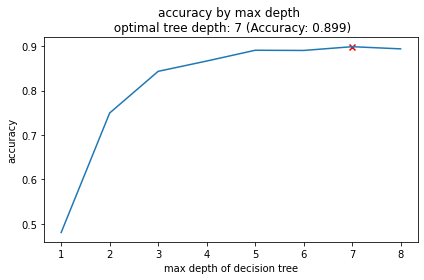

In [81]:
plt.plot(max_depth_list, accuracy_scores)
plt.scatter(optimal_depth, max_accuracy, marker  ='x', color = 'red')
plt.title(f"accuracy by max depth \n optimal tree depth: {optimal_depth} (Accuracy: {round (max_accuracy, 4)})")
plt.xlabel('max depth of decision tree')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

# Random Forest <a name="rf-title"></a>

We will again utlise the scikit-learn library within Python to model our data using a Random Forest. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment

Again, since we saved our modelling data as a pickle file, we import it.  We ensure we remove the id column, and we also ensure our data is shuffled.


In [9]:
from sklearn.ensemble import RandomForestRegressor
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


In [10]:
data_for_model = pickle.load(open('abc_regression_modelling.p', 'rb'))

In [12]:
data_for_model

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
...,...,...,...,...,...,...,...,...,...,...
862,4,2.14,M,0.64,0.564,3499.39,278,47,5,74.455106
865,372,4.38,F,0.50,0.321,3423.01,338,49,5,69.857347
866,104,2.36,F,0.63,0.587,3648.08,280,49,5,74.450612
868,373,0.21,M,0.47,0.972,3303.80,264,51,5,64.780392


In [13]:
data_for_model.drop('customer_id', axis = 1, inplace= True)

In [14]:
data_for_model

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
...,...,...,...,...,...,...,...,...,...
862,2.14,M,0.64,0.564,3499.39,278,47,5,74.455106
865,4.38,F,0.50,0.321,3423.01,338,49,5,69.857347
866,2.36,F,0.63,0.587,3648.08,280,49,5,74.450612
868,0.21,M,0.47,0.972,3303.80,264,51,5,64.780392


In [5]:
# Shuffle data, just in case 
data_for_model= shuffle(data_for_model, random_state=42)


In [15]:
# Deal with missing values
print(data_for_model.isna().sum()/len(data_for_model))
data_for_model.shape

distance_from_store       0.0050
gender                    0.0075
credit_score              0.0050
customer_loyalty_score    0.0000
total_sales               0.0000
total_items               0.0000
transaction_count         0.0000
product_area_count        0.0000
average_basket_value      0.0000
dtype: float64


(400, 9)

In [16]:
# drop nulls
data_for_model.dropna(how = 'any', inplace=True)


In [17]:
data_for_model.shape

(394, 9)

In [59]:
# do not need to remove outliers in a random forest model same as a decision tree, does not affect the algorithm success



In [18]:
# split data into X and y 
X = data_for_model.drop('customer_loyalty_score', axis =1 )
y = data_for_model['customer_loyalty_score']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 745 to 221
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance_from_store   315 non-null    float64
 1   gender                315 non-null    object 
 2   credit_score          315 non-null    float64
 3   total_sales           315 non-null    float64
 4   total_items           315 non-null    int64  
 5   transaction_count     315 non-null    int64  
 6   product_area_count    315 non-null    int64  
 7   average_basket_value  315 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 22.1+ KB


In [21]:
# Deal with categorical variables
categorical_vars = ['gender']
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first')
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)




C:\Users\Ibiene\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True),X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)


In [23]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop = True),X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)

In [24]:
X_test.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.30,0.59,1959.14,344,39,3,50.234359,0.0
1,2.58,0.58,333.26,70,13,4,25.635385,0.0
2,1.03,0.85,1082.51,214,56,5,19.330536,0.0
3,1.53,0.60,1749.87,330,46,4,38.040652,1.0
4,2.14,0.64,3499.39,278,47,5,74.455106,1.0


In [25]:
X_train.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,4.00,0.52,293.35,68,12,4,24.445833,0.0
1,0.59,0.57,900.09,217,54,4,16.668333,0.0
2,1.06,0.66,1593.04,276,45,3,35.400889,1.0
3,2.32,0.42,1839.89,311,44,4,41.815682,0.0
4,2.28,0.45,70.67,23,4,3,17.667500,0.0


In [26]:
# feature selection : not needed. In a decision tree, each variable is judged independently. but also does not hurt to do feature selection 



In [27]:
regressor = RandomForestRegressor(random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
y_pred = regressor.predict(X_test)

In [29]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.9373939376071163


In [31]:
#Cross Validation
cv = KFold(n_splits = 4, shuffle = True, random_state= 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
cv_scores.mean()


0.934444247762464

In [34]:
y_pred = regressor.predict(X_test)

In [35]:
# Adjusted R squared 

num_data_points , num_input_vars = X_test.shape
num_data_points, num_input_vars

adjusted_r_sqaured = 1 - (1-r_squared)*(num_data_points -1 )/(num_data_points-num_input_vars-1)

In [36]:
adjusted_r_sqaured

0.9302389590479296

In [37]:
#feature importance

regressor.feature_importances_



array([0.69188129, 0.01008603, 0.08685974, 0.09500222, 0.03260982,
       0.055588  , 0.02146139, 0.0065115 ])

In [38]:
feature_importance_summary = pd.DataFrame({'feature_names': X.columns, 
                                   'feature_importance': regressor.feature_importances_})

In [43]:
feature_importance_summary

,feature_names,feature_importance
7,average_basket_value,0.006512
1,gender,0.010086
6,product_area_count,0.021461
4,total_items,0.032610
5,transaction_count,0.055588
2,credit_score,0.086860
3,total_sales,0.095002
0,distance_from_store,0.691881


In [39]:
feature_importance_summary.sort_values(by = 'feature_importance', inplace=True)

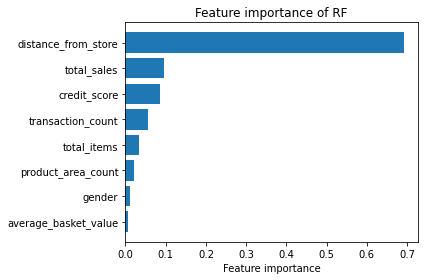

In [41]:
plt.barh(feature_importance_summary.feature_names, feature_importance_summary.feature_importance)
plt.title("Feature importance of RF")
plt.xlabel('Feature importance')
plt.tight_layout()
plt.show()

In [42]:
import plotly.express as px


In [49]:
fig = px.bar(feature_importance_summary, x = 'feature_importance', y= 'feature_names', title = 'Feature Importance of Random Forest')
fig.show()

In [47]:
# using permutation feature importance - decrease in model performance when particular features are randomly shuffled. A large 
# decrease in model accuracy indicates that those features are really important. most cases , both will give the same results

result = permutation_importance(regressor, X_test, y_test, n_repeats = 10, random_state =42)




In [48]:
result

{'importances_mean': array([1.31844726, 0.00164654, 0.08077605, 0.14076953, 0.01741201,
        0.05876616, 0.00603683, 0.0057248 ]),
 'importances_std': array([0.18586841, 0.00121101, 0.0121276 , 0.02612339, 0.00473493,
        0.01230127, 0.00239846, 0.00185897]),
 'importances': array([[ 1.34315258e+00,  1.43444151e+00,  1.20578995e+00,
          1.03942001e+00,  1.05143157e+00,  1.54743544e+00,
          1.51317941e+00,  1.57522918e+00,  1.23154564e+00,
          1.24284733e+00],
        [ 1.16584675e-03,  2.44568332e-03,  1.80588448e-03,
          1.63793566e-03,  1.54285340e-03,  3.05025724e-03,
         -1.77189275e-04,  2.89996031e-04,  6.74661467e-04,
          4.02947214e-03],
        [ 8.53553601e-02,  7.97173295e-02,  6.38743244e-02,
          1.05066776e-01,  6.86031359e-02,  6.75335313e-02,
          9.61990365e-02,  8.00126421e-02,  7.83560046e-02,
          8.30423217e-02],
        [ 1.42041365e-01,  1.04266236e-01,  1.03624763e-01,
          1.30358196e-01,  1.36835532

In [57]:
permutation_importance_summary= pd.DataFrame({'feature_names': X.columns, 
                                   'permutation_importance': result.importances_mean})

In [64]:
permutation_importance_summary.sort_values(by = 'permutation_importance', inplace= True)

In [65]:
permutation_importance_summary

,feature_names,permutation_importance
1,gender,0.001647
7,average_basket_value,0.005725
6,product_area_count,0.006037
4,total_items,0.017412
5,transaction_count,0.058766
2,credit_score,0.080776
3,total_sales,0.140770
0,distance_from_store,1.318447


In [66]:
fig = px.bar(permutation_importance_summary, x = 'permutation_importance', y= 'feature_names', title = 'Permuatation Importance of Random Forest')
fig.show()

In [ ]:
#predictions under the hood

In [67]:
X_test

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.30,0.59,1959.14,344,39,3,50.234359,0.0
1,2.58,0.58,333.26,70,13,4,25.635385,0.0
2,1.03,0.85,1082.51,214,56,5,19.330536,0.0
3,1.53,0.60,1749.87,330,46,4,38.040652,1.0
4,2.14,0.64,3499.39,278,47,5,74.455106,1.0
...,...,...,...,...,...,...,...,...
74,0.22,0.69,6795.14,1019,103,5,65.972233,1.0
75,2.00,0.64,1964.61,325,40,3,49.115250,0.0
76,0.56,0.65,1995.60,194,49,5,40.726531,1.0
77,0.91,0.54,2388.31,272,54,5,44.227963,1.0


In [68]:
y_pred[0]

0.40086999999999984

In [69]:
new_data =[X_test.iloc[0]]

In [70]:
regressor.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(max_features='auto', random_state=1935803228),
 DecisionTreeRegressor(max_features='auto', random_state=787846414),
 DecisionTreeRegressor(max_features='auto', random_state=996406378),
 DecisionTreeRegressor(max_features='auto', random_state=1201263687),
 DecisionTreeRegressor(max_features='auto', random_state=423734972),
 DecisionTreeRegressor(max_features='auto', random_state=415968276),
 DecisionTreeRegressor(max_features='auto', random_state=670094950),
 DecisionTreeRegressor(max_features='auto', random_state=1914837113),
 DecisionTreeRegressor(max_features='auto', random_state=669991378),
 DecisionTreeRegressor(max_features='auto', random_state=429389014),
 DecisionTreeRegressor(max_features='auto', random_state=249467210),
 DecisionTreeRegressor(max_features='auto', random_state=1972458954),
 DecisionTreeRegressor(max_f

In [71]:
predictions = []
tree_count = 0
for tree in regressor.estimators_:
    prediction = tree.predict(new_data)[0]
    predictions.append (prediction)
    tree_count += 1

In [72]:

#show the predictions per decision tree
predictions

[0.382,
 0.668,
 0.297,
 0.448,
 0.366,
 0.366,
 0.439,
 0.439,
 0.448,
 0.208,
 0.38199999999999995,
 0.313,
 0.366,
 0.35,
 0.506,
 0.344,
 0.344,
 0.313,
 0.382,
 0.366,
 0.448,
 0.382,
 0.382,
 0.439,
 0.439,
 0.366,
 0.439,
 0.668,
 0.366,
 0.448,
 0.366,
 0.344,
 0.7,
 0.272,
 0.668,
 0.366,
 0.342,
 0.366,
 0.448,
 0.229,
 0.439,
 0.366,
 0.344,
 0.448,
 0.382,
 0.439,
 0.382,
 0.668,
 0.668,
 0.439,
 0.439,
 0.366,
 0.448,
 0.48,
 0.439,
 0.366,
 0.229,
 0.382,
 0.36599999999999994,
 0.645,
 0.439,
 0.313,
 0.313,
 0.366,
 0.366,
 0.366,
 0.439,
 0.382,
 0.224,
 0.313,
 0.366,
 0.439,
 0.549,
 0.439,
 0.439,
 0.366,
 0.265,
 0.366,
 0.439,
 0.366,
 0.216,
 0.366,
 0.35,
 0.297,
 0.366,
 0.439,
 0.366,
 0.35,
 0.382,
 0.48,
 0.272,
 0.549,
 0.229,
 0.668,
 0.313,
 0.448,
 0.382,
 0.208,
 0.545,
 0.366]

In [73]:
sum(predictions)/tree_count

# basically the RF regressor takes an average of individual decision trees

0.40086999999999984

In [77]:
import numpy as np

In [78]:
np.mean(predictions)

0.40086999999999995

In [79]:
import pickle 

In [81]:
pickle.dump(regressor, open("data/random_forest_regression_model.p", 'wb'))

In [82]:
pickle.dump(one_hot_encoder, open("data/random_forest_regression_model_ohe.p", 'wb'))